In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import get_image_data

In [4]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

Number of hand-made annotations:  4483
2839 1644
2821


In [5]:
import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

[0.32825239276852181, 0.33002481389578164, 0.34172279333569655]

In [6]:
from xy_providers import DataCache, load_data_cache, save_data_cache
try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(0)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(0)

Load cache from pickle file


In [7]:
len(cache.cache), len(cache.ids_queue)

(2821, 2821)

In [8]:
os.environ['KERAS_BACKEND']='tensorflow'

# import tensorflow as tf
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)
# from keras import backend as K
# K.tensorflow_backend.set_session(session=sess)

from custom_mix_cnn_keras_v2 import get_mixed_cnn

Using TensorFlow backend.


In [9]:
from keras import backend as K
print(K.backend(), K.image_data_format())

tensorflow channels_last


In [ ]:
#cnn = get_mixed_cnn()
#cnn.summary()

In [ ]:
#from keras.utils.vis_utils import model_to_dot
#from IPython.display import SVG

#SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# ####################################################
#  Setup NN parameters
# ####################################################
from cv_utils import generate_trainval_kfolds
from data_utils import to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import find_best_weights_file2

seed = 54321
optimizer = 'nadam_accum'
accum_iters = 8
image_size = (224, 224)

nb_epochs = 50
batch_size = 4
lr_base = 0.001
init_epoch = 0
a = 0.957

load_best_weights = False


# ####################################################
#  Start CV
# ####################################################
from training_utils import exp_decay, step_decay

n_folds = 4
val_fold_index = 0
val_fold_indices = [3,]

hists = []

for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    save_prefix = 'mixed_cnn_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get mixed cnn model ...".format(datetime.now()))
    cnn = get_mixed_cnn(optimizer=optimizer, lr=lr_base, accum_iters=accum_iters)

    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename, by_name=True)

    # lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7)
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=a, init_epoch=init_epoch)
    # lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn,
              train_id_type_list,
              val_id_type_list,
              option='cervix', 
              normalize_data=False,
              normalization='',
              nb_epochs=nb_epochs,
              samples_per_epoch=2 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=image_size[::-1],
              seed=seed,              
              save_prefix=save_prefix)    
    if h is None:
        continue
    hists.append(h)
    



 ---- Validation fold index:  3 / 4
2139 724
[0.3380084151472651, 0.32632071061243573, 0.33567087424029923]
[0.30939226519337015, 0.35082872928176795, 0.33977900552486184]

 2017-06-06 23:53:52.175038 - Get mixed cnn model ...

 2017-06-06 23:54:24.397391 - Start training ...

-- Training parameters: 4, 50, 4280, 728

-- Fit model
- New Keras API found -
Epoch 1/50
  33/1070 [..............................] - ETA: 1641s - loss: 1.5317 - categorical_crossentropy: 1.5317 - categorical_accuracy: 0.3333

In [14]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_loss'], label='val_loss, fold %i' % i)
    plt.plot(h.history['loss'], label='loss, fold %i' % i)   
    plt.legend()


plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_categorical_accuracy'], label='val_categorical_accuracy, fold %i' % i)
    plt.plot(h.history['categorical_accuracy'], label='categorical_accuracy, fold %i' % i)   
    plt.legend()
    
# plt.figure(figsize=(12, 4))
# ll = len(hists)
# for i, h in enumerate(hists):
#     plt.subplot(1, ll, i+1)
#     plt.plot(h.history['val_precision'], label='val_precision, fold %i' % i)
#     plt.plot(h.history['precision'], label='precision, fold %i' % i)   
#     plt.legend()
    
# plt.figure(figsize=(12, 4))
# ll = len(hists)
# for i, h in enumerate(hists):
#     plt.subplot(1, ll, i+1)
#     plt.plot(h.history['val_recall'], label='val_recall, fold %i' % i)
#     plt.plot(h.history['recall'], label='recall, fold %i' % i)   
#     plt.legend()

In [10]:
from visu_utils import compute_layer_outputs
import matplotlib.pylab as plt
%matplotlib inline

In [12]:
layer_output_f_dict = {}

In [13]:
layer_names=['block6_sepconv1_act', 
             'block7_sepconv1_act', 
             'block8_sepconv1_act', 
             'block9_sepconv1_act',              
             'block10_sepconv1_act',
             'block11_sepconv1_act',
             'block12_sepconv1_act',
             'block13_sepconv1_act',
             'block14_sepconv2_act',
            ]

In [20]:
from training_utils import get_train_gen_flow, get_val_gen_flow
from image_utils import scale_percentile

val_fold_index = 0
n_folds = 4
save_prefix = 'mixed_cnn_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

train_gen, train_flow = get_train_gen_flow(train_id_type_list=trainval_id_type_list,
                                             normalize_data=False,
                                             normalization='',
                                             batch_size=1,
                                             seed=seed,
                                             image_size=image_size,
                                             option='cervix',
                                             save_prefix=save_prefix,
                                             xy_provider_cache=cache,
                                             verbose=1)



 ---- Validation fold index:  0 / 4


In [21]:
print("\n {} - Get mixed cnn model ...".format(datetime.now()))
cnn = get_mixed_cnn(optimizer=optimizer, lr=lr_base)

if load_best_weights:
    weights_files = glob("weights/%s*.h5" % save_prefix)
    if len(weights_files) > 0:
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename, by_name=True)


 2017-06-05 18:38:33.334636 - Get mixed cnn model ...


Image y =  [[0 0 1]]
Image y =  [[0 0 1]]
Image y =  [[0 1 0]]
Image y =  [[0 1 0]]
Image y =  [[0 0 1]]


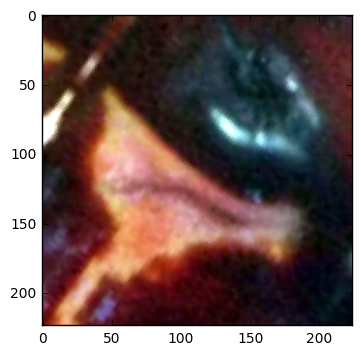

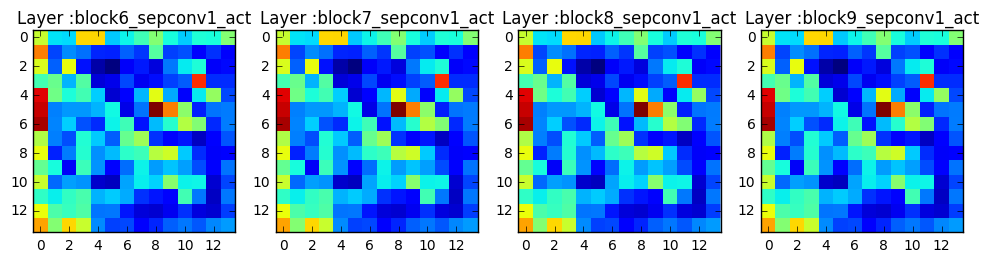

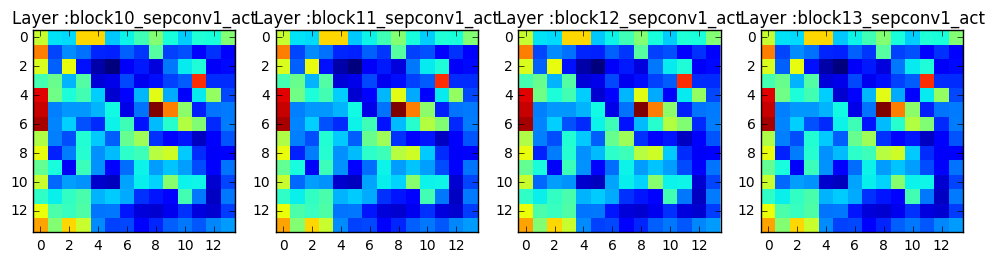

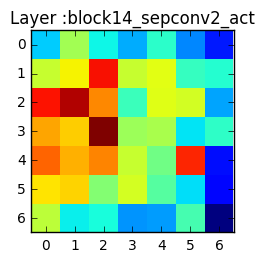

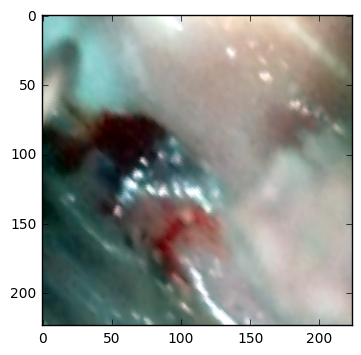

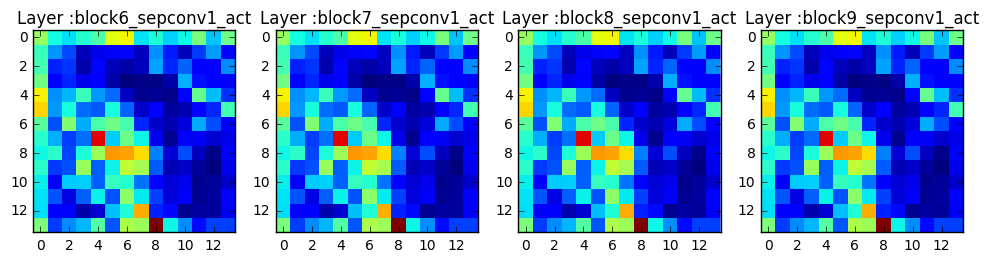

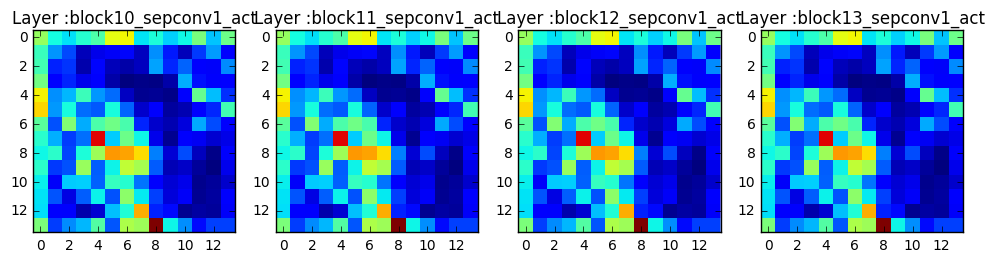

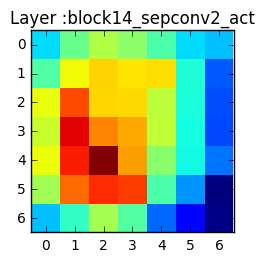

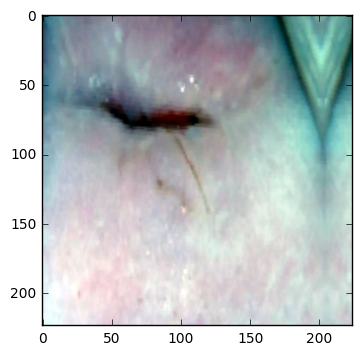

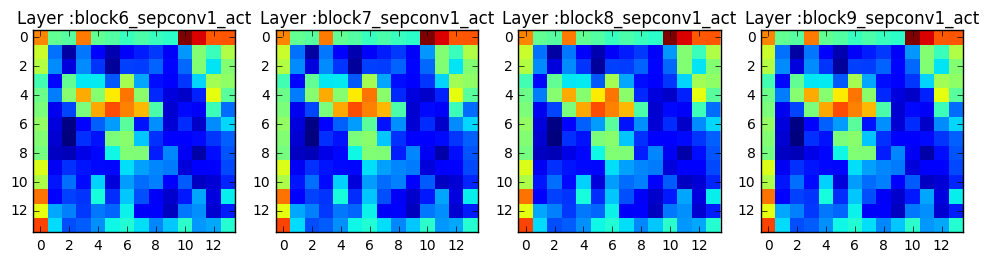

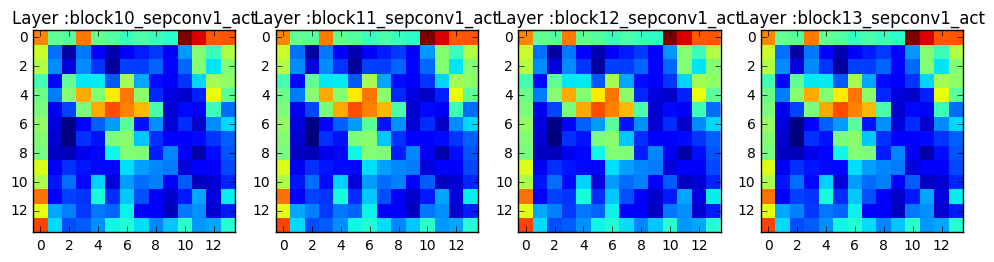

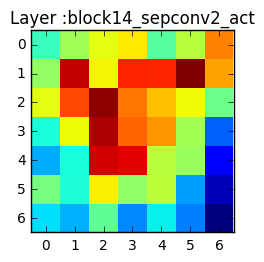

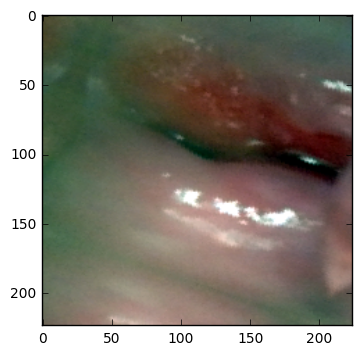

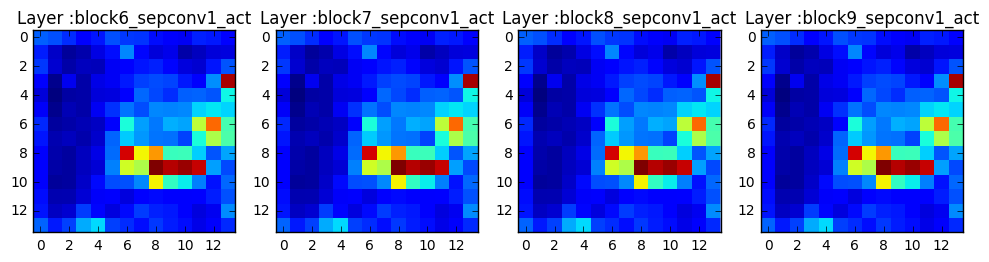

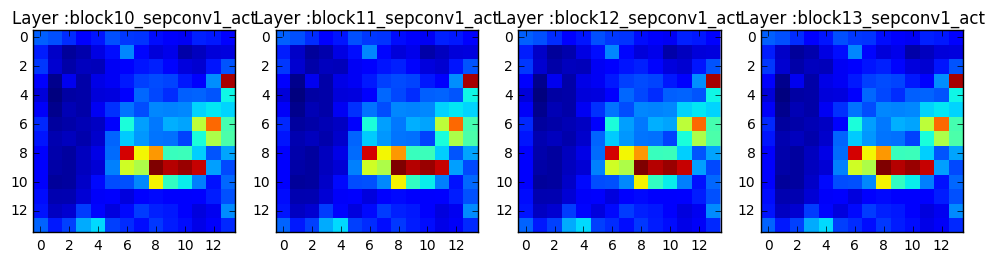

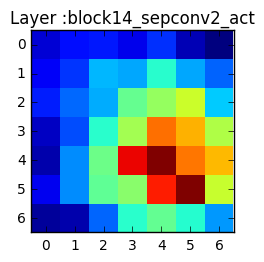

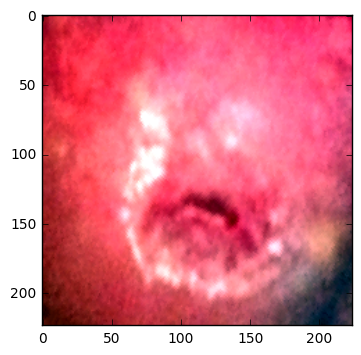

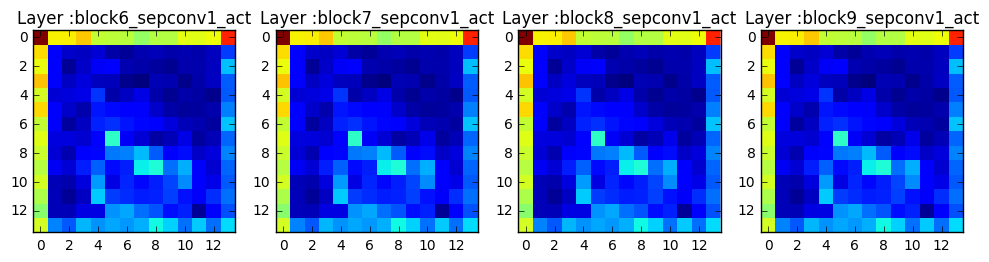

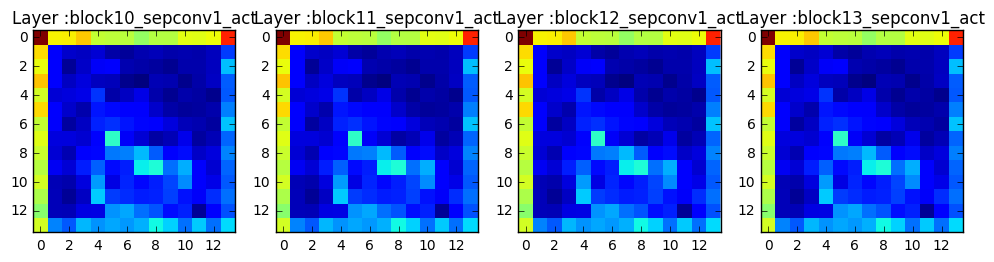

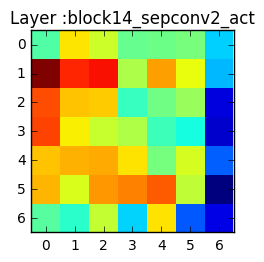

In [22]:
max_counter = 5
for x, y in train_flow:
    layer_outputs = compute_layer_outputs(x, cnn, layer_output_f_dict, layer_names=layer_names)    
    n = 4
    print("Image y = ", y)
    plt.figure(figsize=(12, 4))
    plt.imshow(scale_percentile(x[0, :, :, :]))
    for i, name in enumerate(layer_names):
        img = layer_outputs[name]
        img = np.max(img[0, :, :, :], axis=2)
        if i % n == 0:
            plt.figure(figsize=(12,4))            
        plt.subplot(1, n, i % n + 1)
        plt.imshow(img, interpolation='none')
        plt.title('Layer :' + name)
        
    max_counter -= 1
    if max_counter <= 0:
        break

In [ ]:
# max_counter = 5
# for x, y in train_flow:
#     layer_outputs = compute_layer_outputs(x, cnn, layer_output_f_dict, layer_names=layer_names)    
#     n = 4
#     print("Image y = ", y)
#     plt.figure(figsize=(12, 4))
#     plt.imshow(scale_percentile(x[0, :, :, :]))
#     for i, name in enumerate(layer_names):
#         img = layer_outputs[name]
#         img = np.max(img[0, :, :, :], axis=2)
#         if i % n == 0:
#             plt.figure(figsize=(12,4))            
#         plt.subplot(1, n, i % n + 1)
#         plt.imshow(img, interpolation='none')
#         plt.title('Layer :' + name)
        
#     max_counter -= 1
#     if max_counter <= 0:
#         break

In [44]:
## Cross-validation:

n_runs = 1
seed = 54321
run_counter = 0
cv_mean_losses = np.zeros((n_runs, n_folds))

while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):

        save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        val_fold_index += 1

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
        print(compute_type_distribution(train_id_type_list))
        print(compute_type_distribution(val_id_type_list))

        print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
        cnn = get_cnn(optimizer=optimizer, lr=lr_base)

        weights_files = glob("weights/%s*.h5" % save_prefix)
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        loss = validate(cnn, 
                        val_id_type_list, 
                        option='cervix/os',
                        normalize_data=True,
                        normalization='vgg',
                        image_size=image_size[::-1],
                        save_prefix=save_prefix,
                        batch_size=8,
                        seed=seed + run_counter,
                        verbose=1,
                        xy_provider_cache=cache)   
        cv_mean_losses[run_counter-1, val_fold_index-1] = loss
    
print(cv_mean_losses)



 ---- New run :  1 / 1


 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-28 11:32:13.958432 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_33_val_loss=0.8326_val_acc=0.6168_val_precision=0.6728_val_recall=0.4734.h5 0.8326
Image normalization:  vgg
Image normalization:  vgg
Total loss :  0.840584480266


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-28 11:33:26.632550 - Get custom squeezenet model ...


AssertionError: Failed to load weights

In [45]:
np.mean(cv_mean_losses)

0.14009741337762938

In [36]:
## Predict on test data
from data_utils import test_ids

test_id_type_list = []
for image_id in test_ids:
    test_id_type_list.append((image_id, "Test"))

In [39]:
from test_utils import classification_predict as predict

predictions = []

for val_fold_index in range(n_folds):
    
    save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    cnn = get_cnn(optimizer=optimizer, lr=lr_base)

    weights_files = glob("weights/%s*.h5" % save_prefix)
    assert len(weights_files) > 0, "Failed to load weights"
    best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
    print("Load best loss weights: ", best_weights_filename, best_val_loss)
    cnn.load_weights(best_weights_filename)
    
    df = predict(cnn,
                test_id_type_list, 
                option='cervix/os', 
                normalize_data=True,
                normalization='vgg',
                image_size=image_size[::-1],
                save_prefix=save_prefix,
                batch_size=8,
                seed=seed,
                xy_provider_cache=cache)
    predictions.append(df)
    



 ---- Validation fold index:  0 / 6

 2017-05-28 11:19:40.025825 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_33_val_loss=0.8326_val_acc=0.6168_val_precision=0.6728_val_recall=0.4734.h5 0.8326
Image normalization:  vgg
Image normalization:  vgg
-- 0 / 512
-- 8 / 512
-- 16 / 512
-- 24 / 512
-- 32 / 512
-- 40 / 512
-- 48 / 512
-- 56 / 512
-- 64 / 512
-- 72 / 512
-- 80 / 512
-- 88 / 512
-- 96 / 512
-- 104 / 512
-- 112 / 512
-- 120 / 512
-- 128 / 512
-- 136 / 512
-- 144 / 512
-- 152 / 512
-- 160 / 512
-- 168 / 512
-- 176 / 512
-- 184 / 512
-- 192 / 512
-- 200 / 512
-- 208 / 512
-- 216 / 512
-- 224 / 512
-- 232 / 512
-- 240 / 512
-- 248 / 512
-- 256 / 512
-- 264 / 512
-- 272 / 512
-- 280 / 512
-- 288 / 512
-- 296 / 512
-- 304 / 512
-- 312 / 512
-- 320 / 512
-- 328 / 512
-- 336 / 512
-- 344 / 512
-- 352 / 512
-- 360 / 512
-- 368 / 512
-- 376 / 512
-- 384 / 512
-- 392 / 512
-- 400 / 512
-- 408 / 512
-- 416 / 512
-

AssertionError: Failed to load weights

In [40]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.208982,0.552476,0.238542
1,1.jpg,0.339248,0.552187,0.108565
2,10.jpg,0.591890,0.305741,0.102369
3,100.jpg,0.285142,0.608363,0.106496
4,101.jpg,0.389023,0.513782,0.097195


In [100]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.222587,0.533222,0.244191
1,1.jpg,0.215771,0.542684,0.241544
2,10.jpg,0.330304,0.534667,0.135029
3,100.jpg,0.300007,0.633719,0.066274
4,101.jpg,0.475317,0.412831,0.111853


In [41]:
from datetime import datetime

info = 'fold=0_squeezenet_bn'

now = datetime.now()
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
sub_file = os.path.join('..', 'results', sub_file)
df.to_csv(sub_file, index=False)